# DSCI 572 lecture 4: computing derivatives


In [2]:
import numpy as np
import sklearn
import sklearn.linear_model
import matplotlib.pyplot as plt
%matplotlib inline

Learning goals:

 * compare and contrast symbolic, automatic, and numerical differentiation, (and by-hand!), and discuss the pros and cons of each approach
 * compare and contrast the forward difference formula vs. the centred difference formula
 * implement a simple gradient checker using finite differences
 * interpret a plot of error estimating a derivative vs. h. Specifically explain the non-monotonic U-shape.
 * implement a simple optimizer using AutoGrad

- In the last lecture we discussed numerical issues due to the **floating point** representation.

- It turns out there's an entirely different type of numerical error that arises from **discretization**.

- Consider $f(x)=\sin(x)$. We know that $f'(x)\equiv\frac{df(x)}{dx}=\cos(x)$ and thus $f'(1)=\cos(1)$

In [3]:
np.cos(1)

0.54030230586813977

What if we are optimizing a function and we don't know its derivative that easily. This could happen because

- you're optimizing the parameters of a computer simulation 
  - a robot
  - weather / atmospheric science
  - financial simulation
  - ...
- you're optimizing the hyperparameters of a machine learning algorithm
- the derivative is just too much effort to compute and it's slowing down your prototyping efforts
- ...

What to do??

There are 3 main approaches to computing derivatives with a computer

- symbolic differentiation

- numerical differentiation

- automatic differentiation



## symbolic differentiation

- interpret the symbols and apply the rules of differentiation, sort of like a human does

- see e.g. <https://www.wolframalpha.com/input/?i=derivative+of+sin(cos(x))>

- a useful tool, but less so when deadling with data.

- we will not say more about this now. You should be aware of its existence.


## numerical differentiation

- a derivative is defined as

$$\frac{df(x)}{dx} \equiv \lim_{h\rightarrow 0} \frac{f(x+h)-f(x)}{h} $$

- numerical differentiation: do this even though $h$ is only small and not actually infinitesimal

$$\frac{df(x)}{dx} \approx \frac{f(x+h)-f(x)}{h}$$ for small $h$. This is called **finite differences**.

Let's give it a try!

In [4]:
h = 0.001
f = lambda x: np.sin(x)
x0 = 1
dfdx = (f(x0+h)-f(x0))/h
dfdx

0.5398814803603269

In [5]:
np.cos(1)

0.54030230586813977

Not bad!

Question for all y'all: what do you think will happen to the absolute error of the estimate if I change $h$?

Definition: 

let $f'(1)$ be the true derivative at $x=1$ and $\hat{f'}(1)$ be the estimate. Then the absolute error is defined as

$$\left|f'(1)-\hat{f'}(1)\right|$$

Discuss for a few minutes. 

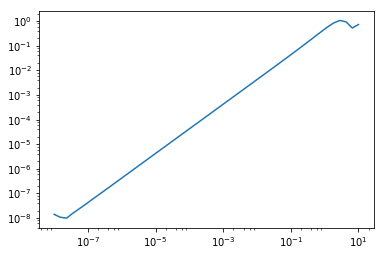

In [6]:
# here's the code
dfdx_estimate = lambda h: (f(1+h)-f(1))/h
dfdx_true = np.cos(1)
abs_error = lambda h: np.abs(dfdx_estimate(h)-dfdx_true)

h = 10**(np.linspace(-8,1))
plt.loglog(h, abs_error(h))
plt.show()

Makes sense, right? But the plot thickens...

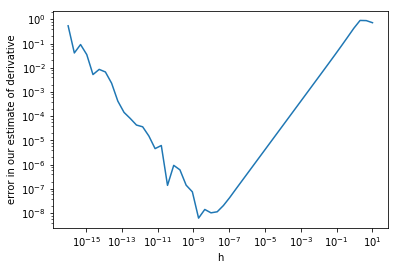

In [7]:
h = 10**(np.linspace(-16,1))
plt.loglog(h, abs_error(h))
plt.xlabel('h')
plt.ylabel('error in our estimate of derivative')

Wait... what?

Discuss for 5 min. 

- Recall lecture 3 (last time). When $h<<1$ we have that $\left| f(x+h)-f(x) \right|<<1$. This leads to _roundoff errors_. Is it underflow?

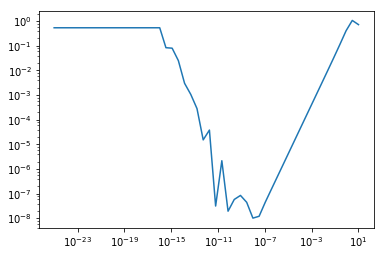

In [8]:
h = 10**(np.linspace(-25,1))
plt.loglog(h, abs_error(h))

So, no, the flat part is underflow (estimate of the derivative is exactly zero). What's up with the part in between, from $10^{-16}$ to $10^{-7}$

- The problem is regular old roundoff error.

- Roughly speaking, the magnitude of these roundoff errors is independent of $h$, and so the $h$ in the denominator causes $\frac{1}{h}$-like behavior.

- We can test this with a line, using our friend $10^{-16}$ from last lecture 
  - (optional) it's actually $2^{-53}$... 52 bits in the mantissa means spacing on the order of $2^{-52}$, which means roundoff error of $2^{-53}$.

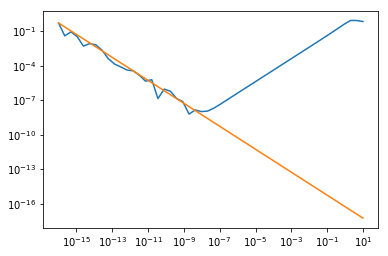

In [9]:
h = 10**(np.linspace(-16,1))
plt.loglog(h, abs_error(h))
plt.loglog(h, 1e-16*dfdx_true/h)

We won't go into the details of how we calculated the line, but we can see the the slope is indeed around 1. We can also look at the other line, which follows our intuition that a small $h$ is good...

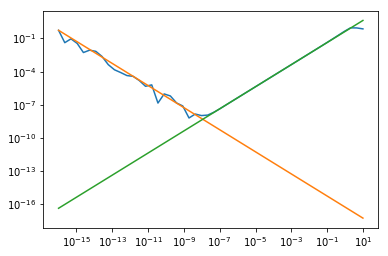

In [10]:
h = 10**(np.linspace(-16,1))
plt.loglog(h, abs_error(h))
plt.loglog(h, 1e-16*abs(dfdx_true)/h)
d2fdx2_true = -np.sin(1) # don't worry about this
plt.loglog(h, abs(d2fdx2_true)/2*h)

Wow!

What have we learned?

- the _numerical approximation_ to the derivative initially increases as $h$ gets smaller

  - this effect is linear in $h$

- however, when $h$ is too small then roundoff error kicks in and the error starts to decrease

  - this effect is linear in $1/h$


Bonus information:

- there was better finite differences formulas than the one we are using, such as 

$$\frac{df(x)}{dx} \approx \frac{f(x+h)-f(x-h)}{2h}$$

- in this case the error goes down as $h^2$, which is great.
- But most of the benefits come in applications that we don't care about here (solving differential equations). 
- OTOH for the right choice of $h$, the total error is lower than with the forward difference formula, so it's still appealing. 
- But, in $d$ dimensions, this requires $2d$ evaluations of the function instead of $d+1$, because with the forward difference formula (the original one above) we reuse the point $f(x)$ in all directions.
- Conclusion: which formula you use depends on what you're doing.

Extra-bonus information -- very, very optional and only if you are truly obsessed with numerical differentiation:

- there are other methods for numerically approximating derivatives; see [chebfun](http://www.chebfun.org/) or the [complex step method](https://www.math.u-psud.fr/~maury/paps/NUM_CompDiff.pdf)

#### taking a step back

What have we learned:

- if we can't figure out the derivative of a function, but have code that computes the function, we can _approximate_ the derivative using the above methods.

- this works pretty well but there are some pitfalls. In particular you need to choose $h$ carefully.

- it seems better to actually know the derivative if possible, because the computations will be faster and more accurate.

- wait, why faster? it doesn't seem like a big deal. Well...

- if you are estimating a gradient you can do the above independently for each dimension, where the step of size $h$ goes in a different direction each time

- Ok, so now you have to evaluate the function in at least $d+1$ places. That sounds annoying. If I can do things in $\mathcal{O}(1)$ function evaluations I'd be a lot happier than if it takes $\mathcal{O}(d)$ function evaluations. Perhaps $d$ is 1000 or 10000. And perhaps function evaluations are slow.

## automatic differentiation (AD)

- AD is another way to take the derivative given some code that computes $f$

- it is sort of in between symbolic and numerical differentiation

(bonus) How it works...

- keep track of the gradient of primitive operations

- apply the chain rule

Demonstration: robust regression from Lecture 2 (the following code is copy/pasted from lecture 2. I should make this into its own file and import it from both lectures ...)

In [20]:
import autograd # pip install autograd
from autograd import grad
import autograd.numpy as np

In [23]:
# generate random data
x = np.random.randn(40)
y = 10*x
# add random outliers
Noutliers = 3
y[:Noutliers] = -100*(x[:Noutliers]+np.random.randn(Noutliers))

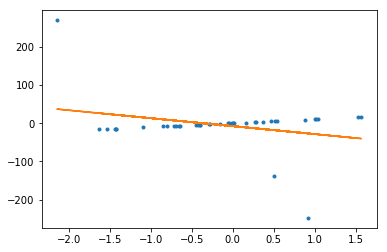

w = -20.800047
b = -7.745678


In [24]:
X = x[:,None] # reshape for sklearn

lr = sklearn.linear_model.LinearRegression()
lr.fit(X,y)
plt.plot(x,y,'.')
plt.plot(x, lr.predict(X))

plt.show()


print("w = %f" % lr.coef_)
print("b = %f" % lr.intercept_)

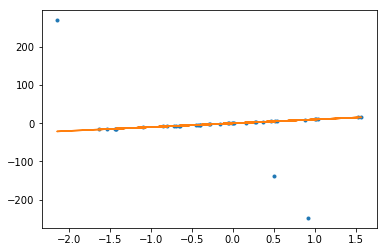

w = 9.961645
b = -0.280000


In [25]:
w = 0
b = 0
alpha = 0.01

Nsteps = 1000
f = lambda x,w,b: w*x+b

for t in range(Nsteps):
    dLdw = -np.sum(x*np.sign(y-f(x,w,b)))
    dLdb = -np.sum(np.sign(y-f(x,w,b)))
    w -= alpha*dLdw
    b -= alpha*dLdb
    
plt.figure()
plt.plot(x,y,'.')
plt.plot(x,w*x+b)
plt.show()

print("w = %f" % w)
print("b = %f" % b)

Get ready...


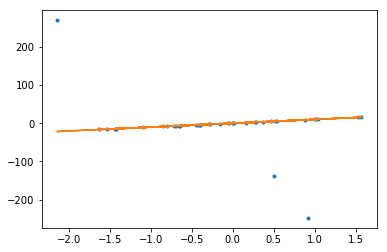

w = 10.055525
b = -0.260000


In [26]:
w = 0.0
b = 0.0
alpha = 0.01

Nsteps = 1000
f = lambda x,w,b: w*x+b
loss = lambda w,b,x,y: np.sum(np.abs(y-f(x,w,b)))

dLdw = grad(loss,argnum=0) # -np.sum(x*np.sign(y-f(x,w,b)))
dLdb = grad(loss,argnum=1) #-np.sum(np.sign(y-f(x,w,b)))
    
for t in range(Nsteps):
    w -= alpha*dLdw(w,b,x,y)
    b -= alpha*dLdb(w,b,x,y)
    
plt.figure()
plt.plot(x,y,'.')
plt.plot(x,w*x+b)
plt.show()

print("w = %f" % w)
print("b = %f" % b)

Wow!!!

If you want to learn more, see [Dougal's thesis](https://dougalmaclaurin.com/phd-thesis.pdf) section 2.5 and Chapter 4.

So what happened here is that autograd knows how to deal with things like `np.sum`, `np.abs`, subtraction, addition, etc. And it just applied the chain rule for us. 

But let's make sure it wasn't cheating and just doing numerical differentiation!!!

In [27]:

Nsteps = 5
def loss(w,b,x,y): 
    print("Evaluated function!") # let us know what it's doing
    return np.sum(np.abs(y-f(x,w,b)))

dLdw = grad(loss,argnum=0)

for t in range(Nsteps):
    print("Step ", t)
    #dLdb = grad(loss,argnum=1)
    w -= alpha*dLdw(w,b,x,y)
    #b -= alpha*dLdb(w,b,x,y)

Step  0
Evaluated function!
Step  1
Evaluated function!
Step  2
Evaluated function!
Step  3
Evaluated function!
Step  4
Evaluated function!


Boom. So each gradient evaluation only required one function evaluation. Instead of $d+1$ (here $d=1$).

The big question:
    
 - does this mean I never need to take a derivative again?
    
Well

 - for prototyping, hopefully not. For production / real-time applications, then probably. In general if you _can_ compute the derivative, and the time investment is relatively reasonable, then you should.
    
Other limitations:

 - many but not all NumPy functions are in there. If you have a new one you'll need to contribute to Autograd
    
 - you have to use Python/NumPy or another language that offers a package like this
 
 - there are some actual limitations, like assigning to arrays
     
(bonus) Connection to DSCI 553:

 - some MCMC packages perform automatic differentiation of the likelihood function, to use more advanced MCMC methods e.g. [HMC](https://en.wikipedia.org/wiki/Hybrid_Monte_Carlo), [NUTS](http://www.stat.columbia.edu/~gelman/research/published/nuts.pdf)


- This hereby ends Part 1 of the course, which was about optimization and derivatives. 
- After the break we'll start on neural networks. We'll use TensorFlow and Keras. By the way, TensorFlow does automatic differentiation much like AutoGrad. So you just specify your model and then you can optimize it using gradient-based methods. This is extremely useful for prototyping. 